# Classical Machine Learning Classification (Multi Label)

This notebook implements classical machine learning classification techniques to categorize research papers into predefined categories based on their titles and abstracts. It uses the combined dataset of existing categorized papers and new papers for training and evaluation.


In [ ]:
from ast import literal_eval

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

## Data Loading & Preprocessing


In [ ]:
# Load the existing categorized papers (after post-processing)
df_existing = pd.read_csv("../data/combined_data_original.csv")
df_existing.head(2)

,title,category,link,authors,year,abstract
0,A Framework to Generate Neurosymbolic PDDL-com...,['plan-generation'],https://arxiv.org/abs/2303.00438,"Capitanelli, Alessio and Mastrogiovanni, Fulvio",2023,Symbolic task planning is a widely used approa...
1,A Prefrontal Cortex-inspired Architecture for ...,['brain-inspired-planning'],https://arxiv.org/abs/2310.00194,"Webb, Taylor and Mondal, Shanka Subhra and Wan...",2023,Large language models (LLMs) demonstrate impre...


In [ ]:
# Load the new papers (CSV format)
df_new = pd.read_csv("../data/newer_all_arxiv_papers_20240925_171114.csv")
df_new.head(2)

,Title,Authors,Published Date,Abstract,URL,Categories,Comments
0,LASP: Surveying the State-of-the-Art in Large ...,"Haoming Li, Zhaoliang Chen, Jonathan Zhang, Fe...",2024-09-03,Effective planning is essential for the succes...,http://arxiv.org/abs/2409.01806v1,"Plan Generation, Goal Decomposition",Survey paper
1,Planetarium: A Rigorous Benchmark for Translat...,"Max Zuo, Francisco Piedrahita Velez, Xiaochen ...",2024-07-03,Many recent works have explored using language...,http://arxiv.org/abs/2407.03321v1,Language Translation,NaN


In [4]:
# Pre-processing: remove row 14, 49, 50
df_new.drop(df_new.index[[11, 48, 49]], inplace=True)
df_new.reset_index(drop=True, inplace=True)

In [ ]:
# Function to standardize category format
def standardize_categories(categories):
    if isinstance(categories, str):
        # Handle string representation of lists
        if categories.startswith("["):
            categories = literal_eval(categories)
        # Handle single string
        elif categories == "-":
            return []
        else:
            # Split by comma and clean up
            categories = [cat.strip() for cat in categories.split(",")]

    # Standardize category names
    standardized = []
    for cat in categories:
        # Convert to lowercase and replace spaces with hyphens
        cat = cat.lower().replace(" ", "-")
        # Remove any special characters if needed
        standardized.append(cat)

    return standardized

In [ ]:
# Combine title and abstract for feature extraction
df_existing["text"] = df_existing["title"] + " " + df_existing["abstract"]
df_new["text"] = df_new["Title"] + " " + df_new["Abstract"]

In [7]:
df_existing.category = df_existing.category.apply(standardize_categories)
df_new.Categories = df_new.Categories.apply(standardize_categories)

In [ ]:
def generate_distribution(df, cat, title):
    # Plot the distribution of categories
    plt.figure(figsize=(6, 3))
    sns.countplot(y=cat, data=df, order=df[cat].value_counts().index)
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Category")
    plt.show()

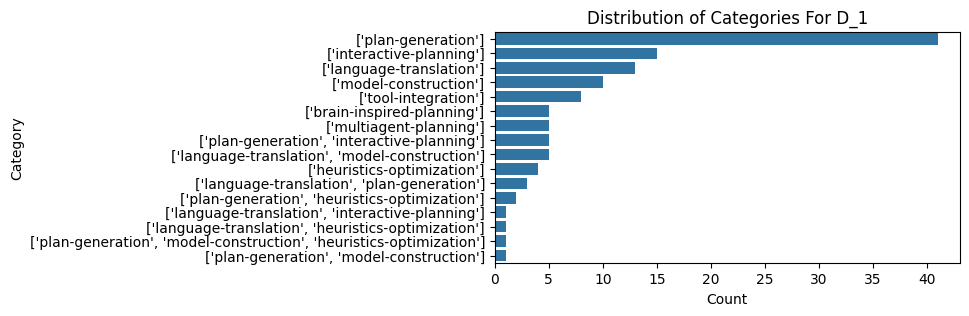

In [ ]:
generate_distribution(df_existing, "category", "Distribution of Categories For D_1")

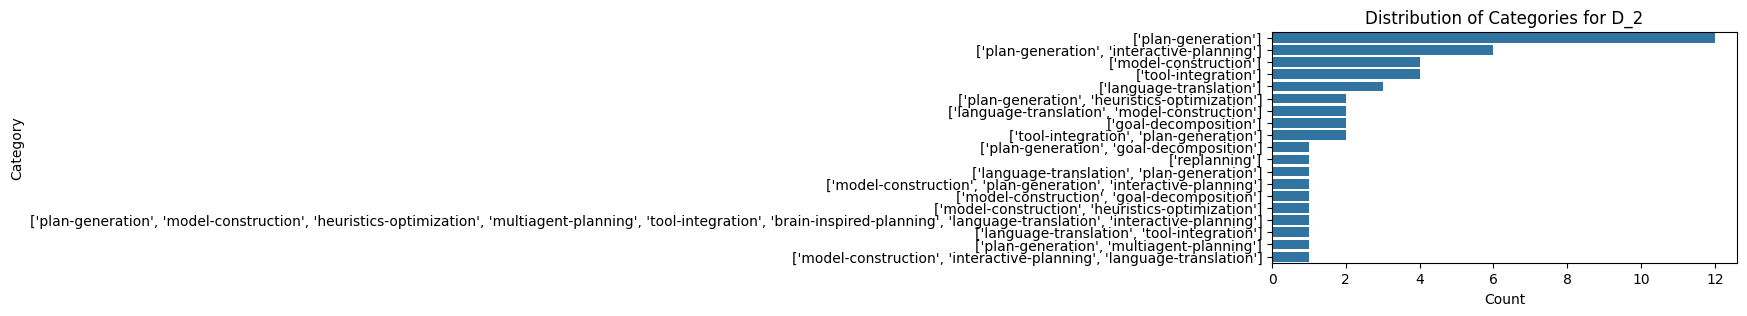

In [ ]:
generate_distribution(df_new, "Categories", "Distribution of Categories for D_2")

<br>


## Create Features


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

X_old = vectorizer.fit_transform(df_existing["text"])
X_new = vectorizer.transform(df_new["text"])

In [ ]:
# Fit MLB only on training categories
mlb = MultiLabelBinarizer()
y_old = mlb.fit_transform(df_existing["category"])

# Transform new data using only the categories from training
y_new = mlb.transform(df_new["Categories"])

/Users/nitingupta/miniconda3/envs/lit-cat/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['goal-decomposition', 'replanning'] will be ignored
  warnings.warn(


<br>


## Train, Evaluate, and Test Model


In [13]:
np.random.seed(42)

In [14]:
# Convert sparse matrix to array for iterative stratification
X_old_array = X_old.toarray()

In [15]:
# Split old data into train and test sets
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [16]:
for train_idx, test_idx in msss.split(X_old_array, y_old):
    X_train = X_old[train_idx]
    X_test = X_old[test_idx]
    y_train = y_old[train_idx]
    y_test = y_old[test_idx]

In [17]:
# Print some information about the split
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (96, 2974)
Test set shape: (24, 2974)


In [ ]:
# Print distribution information
def print_label_distribution(y, set_name):
    label_counts = y.sum(axis=0)
    print(f"\nLabel distribution in {set_name}:")
    for i, count in enumerate(label_counts):
        if count > 0:  # Only print categories that appear
            print(f"{mlb.classes_[i]}: {count}")


print_label_distribution(y_train, "training set")
print_label_distribution(y_test, "test set")


Label distribution in training set:
brain-inspired-planning: 4
heuristics-optimization: 6
interactive-planning: 17
language-translation: 18
model-construction: 14
multiagent-planning: 4
plan-generation: 42
tool-integration: 6

Label distribution in test set:
brain-inspired-planning: 1
heuristics-optimization: 2
interactive-planning: 4
language-translation: 5
model-construction: 3
multiagent-planning: 1
plan-generation: 11
tool-integration: 2


In [ ]:
# For traditional ML models:
models = {
    "dt": MultiOutputClassifier(
        DecisionTreeClassifier(class_weight="balanced", random_state=42)
    ),
    "rf": MultiOutputClassifier(
        RandomForestClassifier(
            n_estimators=100, class_weight="balanced_subsample", random_state=42
        )
    ),
    "ovr": OneVsRestClassifier(
        LinearSVC(class_weight="balanced", random_state=42, max_iter=1000)
    ),
}

In [ ]:
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    results[model_name] = {
        "test_report": classification_report(
            y_test, y_pred_test, target_names=mlb.classes_, zero_division=0, digits=3
        ),
        "predictions": model.predict(X_new),
    }

Training dt...
Training rf...
Training ovr...


/Users/nitingupta/miniconda3/envs/lit-cat/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nitingupta/miniconda3/envs/lit-cat/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nitingupta/miniconda3/envs/lit-cat/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nitingupta/miniconda3/envs/lit-cat/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` expli

In [ ]:
# Print results for the old dataset
for model_name, model_data in results.items():
    print(f"\nResults for {model_name} on test set:")
    print(model_data["test_report"])


Results for dt on test set:
                         precision    recall  f1-score   support

brain-inspired-planning      0.000     0.000     0.000         1
heuristics-optimization      0.000     0.000     0.000         2
   interactive-planning      0.000     0.000     0.000         4
   language-translation      0.333     0.200     0.250         5
     model-construction      0.500     0.333     0.400         3
    multiagent-planning      0.000     0.000     0.000         1
        plan-generation      0.545     0.545     0.545        11
       tool-integration      1.000     0.500     0.667         2

              micro avg      0.375     0.310     0.340        29
              macro avg      0.297     0.197     0.233        29
           weighted avg      0.385     0.310     0.337        29
            samples avg      0.285     0.312     0.278        29


Results for rf on test set:
                         precision    recall  f1-score   support

brain-inspired-planning     

In [ ]:
# Print classification report for the new data
for model_name, model_data in results.items():
    print(f"\nPerformance on new data for {model_name}:")
    print(
        classification_report(
            y_new,
            model_data["predictions"],
            target_names=mlb.classes_,
            zero_division=0,
            digits=3,
        )
    )


Performance on new data for dt:
                         precision    recall  f1-score   support

brain-inspired-planning      0.000     0.000     0.000         1
heuristics-optimization      1.000     0.250     0.400         4
   interactive-planning      0.273     0.333     0.300         9
   language-translation      0.500     0.556     0.526         9
     model-construction      0.375     0.273     0.316        11
    multiagent-planning      0.000     0.000     0.000         2
        plan-generation      0.667     0.519     0.583        27
       tool-integration      1.000     0.500     0.667         8

              micro avg      0.517     0.423     0.465        71
              macro avg      0.477     0.304     0.349        71
           weighted avg      0.579     0.423     0.473        71
            samples avg      0.477     0.428     0.415        71


Performance on new data for rf:
                         precision    recall  f1-score   support

brain-inspired-plann

In [ ]:
# Convert predictions back to categories for all classifiers
for classifier, data in results.items():
    df_new[f"{classifier}_predicted"] = mlb.inverse_transform(data["predictions"])
    print(f"\nPredicted category distribution for {classifier}:")
    print(df_new[f"{classifier}_predicted"].value_counts())


Predicted category distribution for dt:
dt_predicted
(plan-generation,)                                                                   12
()                                                                                    8
(language-translation,)                                                               5
(tool-integration,)                                                                   3
(interactive-planning, plan-generation)                                               3
(interactive-planning, model-construction, plan-generation)                           2
(brain-inspired-planning, model-construction)                                         2
(interactive-planning, language-translation)                                          2
(interactive-planning,)                                                               2
(interactive-planning, language-translation, plan-generation)                         1
(language-translation, plan-generation)                           

In [24]:
df_new.columns

Index(['Title', 'Authors', 'Published Date', 'Abstract', 'URL', 'Categories',
       'Comments', 'text', 'dt_predicted', 'rf_predicted', 'ovr_predicted'],
      dtype='object')

In [ ]:
# Save results to the same CSV
df_new.to_csv("../outputs/ml_multi_final.csv", index=False)

In [ ]:
# Save the decision tree results to a separate CSV
df_new.drop(["text", "rf_predicted", "ovr_predicted"], axis=1).to_csv(
    "../outputs/dt_multi_final.csv", index=False
)

<br>
